<a href="https://colab.research.google.com/github/dkgithub/wiehl24/blob/main/PyTorch_jet_flavor_classification_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on exercise for "Mastering Model Building"
(inspired heavily by previous edition by M.Rieger but
 adapted to PyTorch)

Before we start with the actual tutorial, the notebook needs to be quickly set up. For this, execute the next cell which installs some dependencies that are not deployed by default on colab. This should only take a couple seconds.

In [ ]:
#!rm -rf helpers
![ ! -d helpers ] && git clone --recursive https://github.com/dkgithub/erum_ml_school_helpers helpers
!pip install wget torchinfo skorch

To verify that the setup worked, run the next cell which imports the `helpers` package that we will use below. The tutors will gladly help you in case you spot an issue 😀

In [ ]:
# load the helpers package and other software
import helpers as hlp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

No issues? Great 🎉!

# Jet classification using PyTorch

<br />
<img src="https://github.com/dkgithub/wiehl24/blob/main/img/top.png?raw=true" width="500" >

(image: https://www.particlezoo.net/)





# Introduction

Our task will be to discriminate between jets produced by a hadronically decaying top quark (**top jet**), or jets produced by a light flavour quark or a gluon (**light / QCD jet**).
Both hadronize into a large number of particles:

<center><img src="https://github.com/riga/qu_tf_tutorial/blob/master/assets/top_vs_qcd.png?raw=1" width="60%"/></center>

- Quark/gluon jets fragment into hadrons
- Top quark decays first into three *sub jets* and fragment then into hadrons
- But: at high momentum they may be merged

→ Substructure might be resolvable by a NN and serve as a handle for classification!

<img src="https://github.com/dkgithub/wiehl24/blob/main/img/boosted_top_decay.png?raw=1" />


## Aim and scope of the tutorial

You are given a dataset with information on > 1M jets, containing **kinematic observables** as well a **truth** label (a float value, either 0 or 1) that describes the origin of the jet. You can find more information on the input data in the cells below.

**We will create a neural (NN) network model that, given a jet, uses its kinematic observables as input features to predict its most probable origin ("class" in ML terms)!**

## Extension

In an **extension** of the tutorial, we will learn how to build a NN that serves multiple purposes at the same time. We will try to let the model also predict the four-vector of the initial quark - the actual physics object we are interested in for reconstructing the underlying hard interaction.

---

> The **main goal** is not to write a perfectly working model that is tailored for one specific use case, but rather to get hands-on experience with PyTorch and some of the fundamental concepts used in machine learning today.

## Outline

- Part 1: PyTorch introduction
- Part 2: Refresher of NN terminology
- Part 3: The tutorial dataset
- Part 4: Minimal training and evaluation workflow
- Part 5: Advanced training loop
- Part 6 (opt.): Multi-target network

# Part 1: PyTorch

## PyTorch ingredients

1. NumPy-like array structure with torch **tensors**. See torch_tensor_tutorial_basics.ipynb

In [ ]:
import torch
torch.__version__

'2.1.0+cu121'

In [ ]:
t = torch.arange(5)
print(t)

# all elements * 2
print(t * 2)

# broadcasting as in numpy
t=t[:,None] # None as index to extend number of dimension
print(t.shape,t.T.shape)
A=t-t.T # this is a matrix
print(A)

tensor([0, 1, 2, 3, 4])
tensor([0, 2, 4, 6, 8])
torch.Size([5, 1]) torch.Size([1, 5])
tensor([[ 0, -1, -2, -3, -4],
        [ 1,  0, -1, -2, -3],
        [ 2,  1,  0, -1, -2],
        [ 3,  2,  1,  0, -1],
        [ 4,  3,  2,  1,  0]])


## PyTorch ingredients

2. Built-in operation for neural network building in torch.nn([docs](https://pytorch.org/docs/stable/nn.html))

In [ ]:
# torch provides random numbers
t = torch.randn((1,4,2))
print(t.shape)
print(t)

# multiple activation functions
print(torch.relu(t))
print(torch.sigmoid(t))
# There are multiple namespaces where activation functions appear.
# By historic reasons ...
print(torch.nn.functional.relu(t))
# But different nn.ReLU() <- this is part of a neural net
aRelu = torch.nn.ReLU()
print(aRelu(t))

# softmax along dim=2
torch.softmax(t,dim=2)

# a linear layer
layer=torch.nn.Linear(2,2,bias=True)
layer(t)

torch.Size([1, 4, 2])
tensor([[[ 0.6444,  0.6734],
         [ 0.4658, -1.5312],
         [ 0.6909,  1.3294],
         [ 2.0491, -0.0106]]])
tensor([[[0.6444, 0.6734],
         [0.4658, 0.0000],
         [0.6909, 1.3294],
         [2.0491, 0.0000]]])
tensor([[[0.6557, 0.6623],
         [0.6144, 0.1778],
         [0.6662, 0.7907],
         [0.8859, 0.4973]]])
tensor([[[0.6444, 0.6734],
         [0.4658, 0.0000],
         [0.6909, 1.3294],
         [2.0491, 0.0000]]])
tensor([[[0.6444, 0.6734],
         [0.4658, 0.0000],
         [0.6909, 1.3294],
         [2.0491, 0.0000]]])


tensor([[[ 1.0264, -0.4129],
         [ 0.1383,  1.1700],
         [ 1.2893, -0.8816],
         [ 1.0391, -0.4229]]], grad_fn=<ViewBackward0>)

In [ ]:
# torch numpy bridge
# from_numpy
np_array    = np.array([[1,2],[3,4]])
torch_tensor = torch.from_numpy(np_array)
print( type(torch_tensor), '\n', torch_tensor)

# and back
# .numpy()
print( type(torch_tensor.numpy()), '\n', torch_tensor.numpy())

# if you just need a standard Python number
print(torch_tensor[0,0].item())

<class 'torch.Tensor'> 
 tensor([[1, 2],
        [3, 4]])
<class 'numpy.ndarray'> 
 [[1 2]
 [3 4]]
1


## PyTorch ingredients

3. Most important **automatic differentiation** on regular python code. See autograd tutorial
 (torch_autograd_tutorial.ipynb)

## PyTorch ingredients

Easy placement of tensors and models to computing device, e.g. GPU, MPS (Apple M1 etc.)

```python
#(this is not executable)
if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"
device = torch.device(dev)

# place a tensor
a = torch.zeros(4,3)
a = a.to(device)

# place a network
model = model.to(device)

```
Make sure that you use a runtime with GPU (T4 in Colab). If there is none available, the notebooks works as well with cpu but slower. I have observe a factor of 4 speed up.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('torch',torch.__version__)
print('device type is',device)
if device == 'cuda' :print(torch.cuda.get_device_name())
from os import environ
if "COLAB_TPU_ADDR" in environ and environ["COLAB_TPU_ADDR"]:
  print("A TPU is connected.")


torch 2.1.0+cu121
device type is cpu


# Part 2: NN terminology refresher

Before we dive in, let's quickly introduce a minimal set of NN terminology. This is a recap of what had been discussed in the lecture. Please note that a full introduction into machine learning would be too exhaustive at this point. For more insights, checkout one of the many resources that are publically available.

One of many examples of a well written introduction that even includes code examples and interactive visualizations is the free online book at [neuralnetworksanddeeplearning.com](http://neuralnetworksanddeeplearning.com)
 (see lecture for more references).

<center><img src="https://github.com/riga/qu_tf_tutorial/blob/master/assets/nn_graph.png?raw=1" width="60%"/></center>

- NNs are structured into so-called **layers** that contain **units**.
- We denote the **input layer** with $l = 0$, and the **output layer** with $l = L$.
- When the number of input features we give to the network is $N$, then the input layer will have $N$ units.
- The grey circles in the graph denote **bias units**. Their value is always one to allow for some numeric independence (see below).
- These $N$ input values are **forward passed** to layer $l = 1$. We do not intend to directly feed values into it, nor do we manually extract its output values - hence we call it **hidden layer**.
- The forward pass involves **weights** - these are free parameters, which are updated during training, and can be understood as *fit parameters*. NNs with millions of parameters are common!
- The input to the *i-th* unit in layer $l = 1$, $z_i^l$, is simply the scalar product of the vector of input features and a vector of weights $W_{ij}^{l-1}$,
\begin{align}
z_i^l &= \sum_j W_{ij}^{l-1} \cdot a_j^{l-1} + b_i^{l-1}\\
\Rightarrow z^l &= W^{l-1} \cdot a^{l-1} + b^{l-1}
\end{align}
where the bias unit is considered as an additional input with value 1, multiplied by the weight $b_j^{l-1}$. Each particular value of $W_{ij}^{l-1}$ and $b_j^{l-1}$ is represented by arrows in the diagram. The second line uses a **vectorized formulation** over all $1 \leq j \leq N$ inputs.
- The output $a_i^l$ of this unit is the value of an [**activation** function](https://en.wikipedia.org/wiki/Activation_function) $\sigma$, evaluated at its input $z_i^l$. This reads
$$
\begin{align}
a^l = \sigma^l(z^l) = \sigma_l(W^{l-1} \cdot a^{l-1} + b^{l-1})
\end{align}
$$
in the vectorial form. The same function is applied to all units in the same layer.
- Just like what we did with the input features, these output values can be propagated through the entire network up to the output layer $l = L$. Here, we choose a clever activation function to output the response $y$ that we like the network to learn (more on this later).
- As a whole, we can see the network output $y$ as a function of $x$, given $W$ and $b$. Thus, we can write
$$
\begin{align}
y = y(x | \underbrace{W,b}_{\equiv\ \omega}) = \underbrace{(a^L \circ a^{L-1} \circ \dots \circ a^1)_\omega}_\text{model} (x)
\end{align}
$$
and identify the **model** as the concatenation of all layers given the free parameters $\omega$.
- Besides the clear mathematical construction and rules to perform the forward pass, you might notice some *room for choices*, such as the number of hidden layers, the amount of units per layer, or the activation functions. These are called **hyper-parameters** and it is your task to understand your input data as well as the problem you want to solve, and adjust these parameters in a educated fashion to optimize the network performance.
- It is this exploration of the huge **space** of hyper-parameters what makes working with NNs complex and exciting at the same time!

## Training, overtraining and data splitting

## Network training

A comprehensive desription and explanantion of the *art* of NN training requires a collection of concepts and mathematical proofs that would by far reach beyond the scope of this tutorial. However, if you intend to apply machine learning techniques in the future, it is **highly recommended** to dive into this fascinating topic. Especially the formulation and proof of the **backpropagation** algorithm is of major importance as it paved the way of actual **deep** neural networks! A good place to start is the free online book at [neuralnetworksanddeeplearning.com](http://neuralnetworksanddeeplearning.com).

## Overtraining

During training, a NN receives *examples* in the form of vectors of input features and produces a prediction which can be compared to the *true* value one would expect. Based on the difference between prediction and expectation (in whatever way *difference* is defined), the network receives an either good or bad feedback that is used to update its trainable parameters, ideally leading to an improvement in the next iteration.

However, this process can have some caveats! When the amount of available training examples is very limited, chances are that they might not describe underlying probability distributions with sufficient precision. As a result, the NN might start to develop a bias towards this particular set of examples. Then, after the training phase, when the NN is requested to evaluate examples that it never *saw* before, its ability to infer predictions might differ greatly from what you observed during training. The model fails to **generalize**, which is referred to as **overtraining**.

## Network capacity

<center><img src="https://github.com/riga/qu_tf_tutorial/blob/master/assets/nn_capacity.png?raw=1" width="60%"/></center>

## Data splitting

There are several techniques to monitor and prevent overtraining. One **mandatory** monitoring technique is data splitting. In its easiest form, the entirety of examples is split into three datasets:

- The *training* dataset is used for the actual training procedure.
- The *validation* dataset is **not** used **for** the training itself, but **during** the training to immediately monitor the NN's ability to generalize.
- All actual measurements are performed on an independent *testing* dataset.

This splitting is applied throughout this exercise!

# Part 3: Tutorial dataset

The input data for this tutorial consists of 1 million jets, originating from either
  - hadronically decaying top quarks (our **signal** ✔︎), or
  - dijet QCD events (our **background** ✘),

and clustered using the $k_{T}$ algorithm with $\Delta R$ = 0.8.

<br />

Data was generated using Phythia & Delphes, configured
  - to collide protons at 14 TeV center-of-mass energy,
  - to generate jets with a $p_{T}$ range of [550, 650] GeV (before hadronization ❗️), and
  - **without** mixing in pileup events for simplicity.

### Input features

Per jet, you are given the four-vectors of up to **200** of its *constituents* (i.e., the particles that form the jet by means of clustering).

   - These up to 800 values define your **input features**.
   - Note that not all jets have that many constituents❗️
   - To spare you the trouble of working with uneven (so-called *jagged*) arrays, these "missing" constituents vectors are filled with zeros.

### Training targets

Per jet, you are provided 2 different training targets:

  1. A flag that marks the true origin of the jet
    - `1` for jets from top quark decays
    - `0` for light jets from QCD events
  2. The true four-vector of the initial particle (only for top quarks)

For now, we will focus on the **1.** training target to perform a *classification* to answer the question: **Top or not?**

(Spoiler: the second target is used later on to include an energy regression 🤫)

## Diving into the data

Let's check out the data! It is stored in NumPy arrays across several files, with 50k jets per file. This way, prototyping and test runs are way quicker. You are given

- 20 training files (`"train"`)
- 8 validation files (`"valid"`)
- 8 testing files (`"test"`)

A few tools to perform recurrent tasks such as data loading are available in the dedicated `helpers` package. Let's load two training files and inspect the contents.

In [ ]:
# load the content of two "train" files - may take a few minutes on first loading
# these are numpy arrays
c_vectors, true_vectors, labels = hlp.data.load("train", start_file=0, stop_file=2)
c_vectors.shape, true_vectors.shape, labels.shape

((100000, 200, 4), (100000, 4), (100000, 1))

All arrays have 100k (2 files x 50k jets) *rows* (dimension 0).

- Per jet, we have up to 200 constituents (`c_vectors`) with 4 variables ($E$, $p_x$, $p_y$, $p_z$) each, thus `(200, 4)`.
- The initiating quark `true_vectors` only has 4 values per jet = one 4-vector.
- The `labels`, however, are single values: 0 or 1.

Let's create a few plots to get some insights into our data.

In [ ]:
# define some flags to make four-vector element access more verbose
E, PX, PY, PZ = range(4)
jet_names = ("Top jet", "QCD jets")
is_top = labels.reshape(-1) == 1
is_qcd = labels.reshape(-1) != 1

## Truth distributions

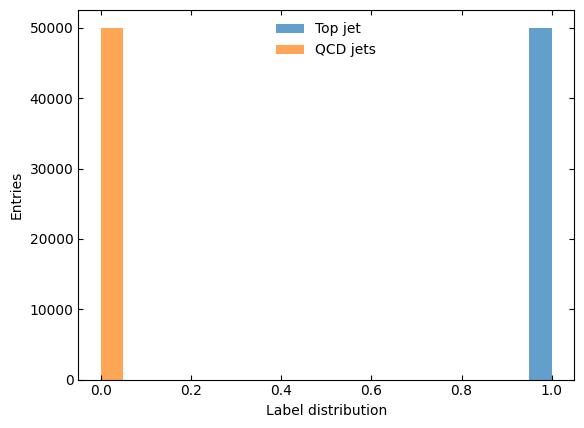

In [ ]:
# distribution of truth labels
hlp.plots.plot_hist(
    (labels[is_top], labels[is_qcd]),
    range=(0, 1),
    names=jet_names,
    xlabel="Label distribution",
).show()

We have equal number of events per class. That makes the training easier.

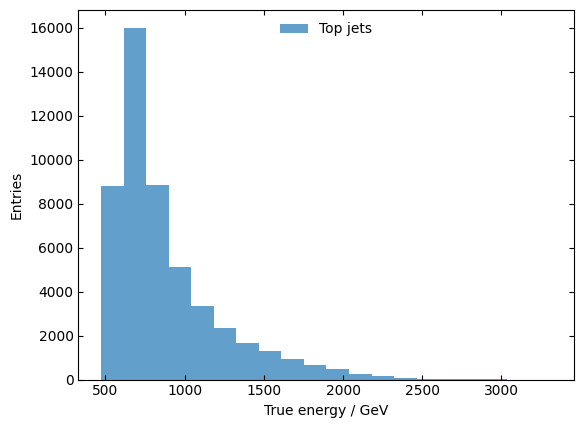

In [ ]:
# energy distribution of the true top quark particle
# remember, this is only available for top jets (zero otherwise)
hlp.plots.plot_hist(
    true_vectors[is_top,E],
    names=("Top jets",),
    xlabel="True energy / GeV",
).show()

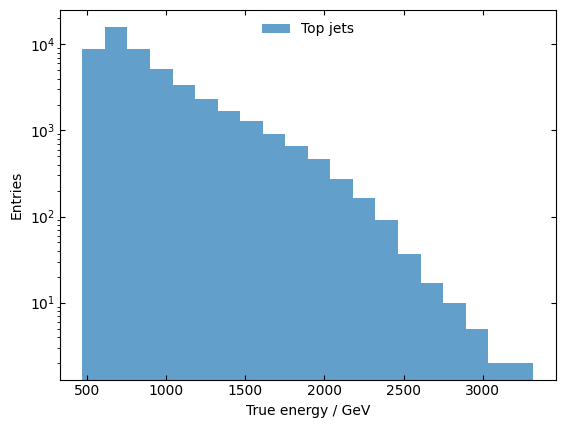

In [ ]:
# energy distribution of the true top quark particle with a log scale
hlp.plots.plot_hist(
    true_vectors[is_top, E],
    names=("Top jets",),
    xlabel="True energy / GeV",
    log=True
).show()

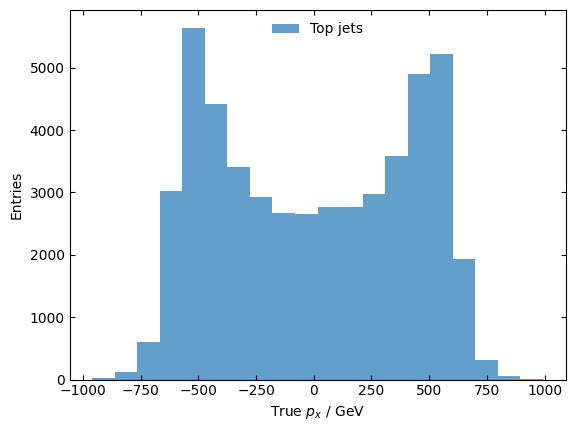

In [ ]:
# px distribution of the true particle
hlp.plots.plot_hist(
    true_vectors[is_top, PX],
    names=("Top jets",),
    xlabel="True $p_x$ / GeV",
).show()

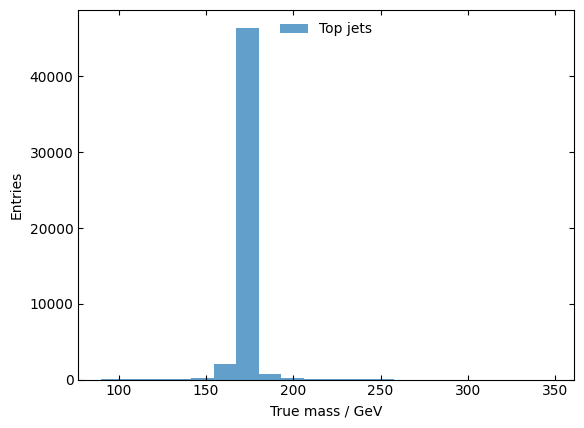

In [ ]:
# mass distribution of the true particle
mass = (true_vectors[:, E]**2 - np.sum(true_vectors[:, PX:]**2, axis=1))**0.5
hlp.plots.plot_hist(
    mass[is_top],
    names=("Top jets",),
    xlabel="True mass / GeV",
    log=False,
).show()

This is indeed a top quark! (it should have a mass of ~172.76 GeV)

## Input feature distributions

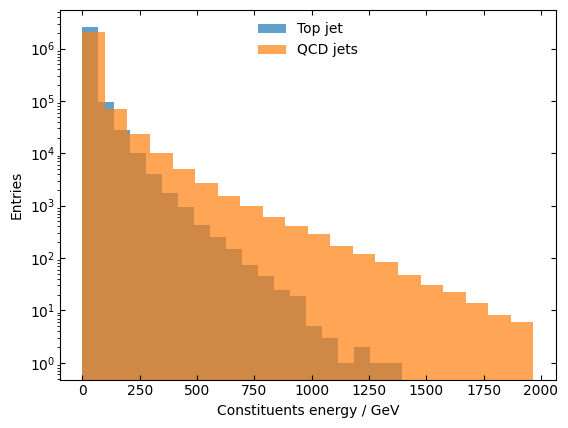

In [ ]:
# energy distribution of all constituents
e_c_top = c_vectors[is_top, :, E].flatten()
e_c_qcd = c_vectors[is_qcd, :, E].flatten()
# store a mask to remove zeros
non_zero_top = e_c_top != 0
non_zero_qcd = e_c_qcd != 0

hlp.plots.plot_hist(
    (e_c_top[non_zero_top], e_c_qcd[non_zero_qcd]),
    names=jet_names,
    log=True,
    xlabel="Constituents energy / GeV",
).show()

In [ ]:
print(f'Minimal energy in top constituenten {e_c_top[non_zero_top].min():3.2e} max {e_c_top.max():3.2e}')
print(f'Minimal energy in top constituenten {e_c_qcd[non_zero_qcd].min():3.2e} max {e_c_qcd.max():3.2e}')
print(f'We have an dynamic range of more then 5 orders of magnitudes.')


Minimal energy in top constituenten 8.73e-03 max 1.40e+03
Minimal energy in top constituenten 1.38e-02 max 1.97e+03
We have an dynamic range of more then 5 orders of magnitudes.


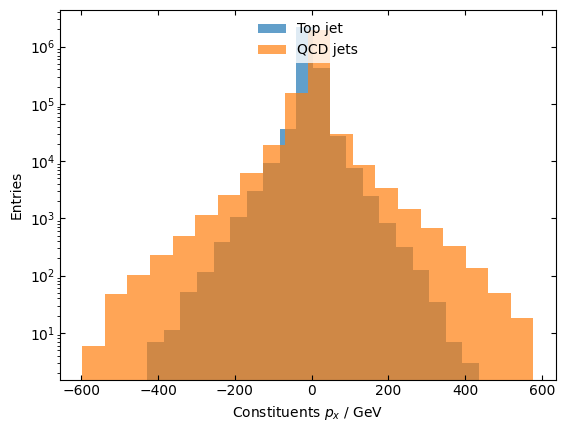

In [ ]:
# px distribution of all constituents, zeros removed with the mask defined above
px_c_top = c_vectors[is_top, :, PX].flatten()
px_c_qcd = c_vectors[is_qcd, :, PX].flatten()

hlp.plots.plot_hist(
    (px_c_top[non_zero_top], px_c_qcd[non_zero_qcd]),
    names=jet_names,
    log=True,
    xlabel="Constituents $p_x$ / GeV",
).show()

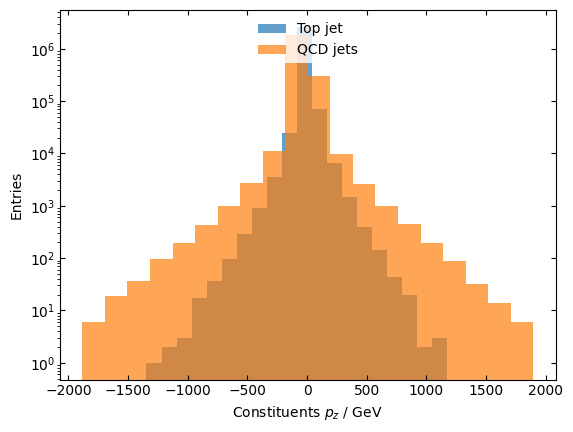

In [ ]:
# pz distribution of all constituents
pz_c_top = c_vectors[is_top, :, PZ].flatten()
pz_c_qcd = c_vectors[is_qcd, :, PZ].flatten()
hlp.plots.plot_hist(
    (pz_c_top[non_zero_top], pz_c_qcd[non_zero_qcd]),
    names=jet_names,
    log=True,
    xlabel="Constituents $p_z$ / GeV",
).show()

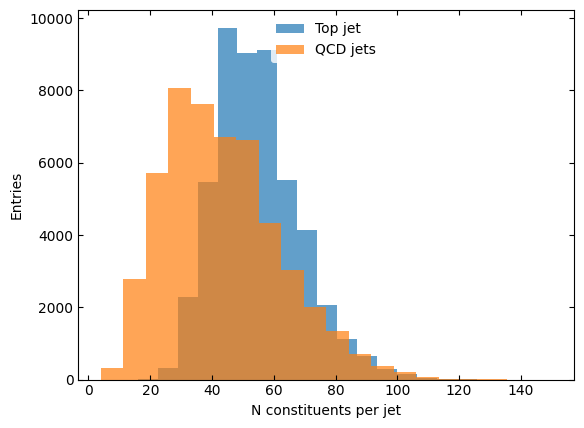

In [ ]:
# number of constituents per jet
# remember, missing constituents are filled with zeros, so we take the energy value as a marker
n_c_top = np.count_nonzero(c_vectors[is_top, :, E], axis=1)
n_c_qcd = np.count_nonzero(c_vectors[is_qcd, :, E], axis=1)
hlp.plots.plot_hist((n_c_top, n_c_qcd), names=jet_names, xlabel="N constituents per jet").show()

## Lessons learned

Altough we are repared to handle *up to* 200 constituents per jet, only a few of them seem to have more than 100 constituents!

Ok, so now that we understood the data, it would not make sense to include all these zeros in a network training. We can safely pick only the first, say, **120 constituents**.

# Part 4: Minimal training and evaluation workflow

In PyTorch the deep learning *mechanics* is easily visible. We must
* Construct the **learning loop** explicitly,
  * Here, the torch **dataloader** is used
* Define an **optimizer**,
* Calculate the **loss**,
* Calculate and apply the **gradient**
* Check the loss development, accuracy etc.

Before we study the possible improvements, we define a base model as starting point. First, we have to decide how to feed the data into the network. We start with just flattening the first 120 4-vectors. This gives as 480 dimensional input vector.


In [ ]:
# first, we define a preprocessing function that (e.g.) takes the
# constiuents and returns an other representation of them
# in this case, we select only the first 120 constituents and
# flatten the resulting array from (..., 120, 4) to (..., 480,)
# i.e. we just apply a simple feedforward network and all constituents
# are treated equally
def preprocess_constituents(constituents):
    return constituents[:, :120].reshape((-1, 480))
# later we try something more fancy
#def preprocess_constituents(constituents):
#     c_sum=constituents.sum(axis=1)
#     metric=np.array([1.,-1.,-1.,-1.])
#     c_inv=(constituents*metric*c_sum[:,None,:]).sum(axis=2)
#     return c_inv

* For binary classifier we can either use 2 outputs with softmax or, what we will do, 1 output with a sigmoid final node. The (0,1) labels are just appropriate for this.
* We could load more data but to observe our models 100k are sufficient for now. The traing will be a bit faster. For best results, we will eventually load all 8 files.

In [ ]:
# load more training, and also validation data
# (increase the numbers if your system allows it)
#c_vectors_train, _, labels_train = hlp.data.load("train", stop_file=8)
#c_vectors_valid, _, labels_valid = hlp.data.load("valid", stop_file=2)
c_vectors_train, _, labels_train = hlp.data.load("train", stop_file=2)
# the validation data is not yet loaded. It will take a few minutes on first load
c_vectors_valid, _, labels_valid = hlp.data.load("valid", stop_file=1)

# run the preprocessing
c_vectors_train = preprocess_constituents(c_vectors_train)
c_vectors_valid = preprocess_constituents(c_vectors_valid)

In [ ]:
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
##scaler = MinMaxScaler()  # worst idea
#scaler.fit(c_vectors_train)
#c_vectors_train=scaler.transform(c_vectors_train)
#c_vectors_valid=scaler.transform(c_vectors_valid)

* Our data consists of *numpy arrays*. We first create *torch.tensors* from them.
* PyTorch provides a class *dataset*. It is useful to zip together data and target/label.

In [ ]:
# We created torch tensors from numpy arrays, map to float32 and move to GPU if available

c_tensor_train      = torch.from_numpy(c_vectors_train).float().to(device)
label_tensor_train  = torch.from_numpy(labels_train).float().to(device)

c_tensor_valid      = torch.from_numpy(c_vectors_valid).float().to(device)
label_tensor_valid  = torch.from_numpy(labels_valid).float().to(device)

c_vectors_train.shape, label_tensor_train.shape,c_vectors_valid.shape

((100000, 480), torch.Size([100000, 1]), (50000, 480))

In [ ]:
# Then, we create a dataset from our tensors
# dataset: a special torch data structure that can be used within a dataloader

dataset_train = torch.utils.data.TensorDataset(c_tensor_train,label_tensor_train)

* The PyTorch *dataloader* fulfils  several purposes. Most important for us, it cuts the data into random (*shuffle*) batches of *batch_size*.

In [ ]:
# Next, we build the the dataloader

batch_size=500
train_loader  = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle = True)
n_inner=float(len(train_loader))

print(f'The dataloader is able to produce {int(n_inner):3d} batches of {batch_size} data points each.')

The dataloader is able to produce 200 batches of 500 data points each.


The easiest way in PyTorch to create a simple network is the *Sequential class*. Complex models are typically defined as a special derived classes.

In [ ]:
import torch
from torch import nn, optim

import torchinfo # for nice model summary

# define the model
# - 2 hidden layers
# - 128 units each
# - tanh activation
# - 1 output unit with sigmoid activation

model = nn.Sequential(
    nn.Linear(480, 256, bias=True),
    nn.Tanh(),
    #nn.BatchNorm1d(256),
    nn.Linear(256, 128, bias=True),
    nn.Tanh(),
    nn.Linear(128,   1, bias=True),
    nn.Sigmoid(),
)


# If available, move the model to the GPU - if not, device had been set to 'cpu' above.
model = model.to(device)
# We use Adam as optimizer and start with learning rate 0.005
optimizer = optim.Adam(model.parameters(), lr=0.005)

# To make your life easier, the helpers provide a
# history object for plotting the learning curves
# We track the average loss, the loss on the validation samples,
# and the accuracy on the validation sample
# (accuracy = fraction of correctly classified events).

L = hlp.plots.history("loss","val_loss","acc") # for learning curves
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            123,136
├─Tanh: 1-2                              --
├─Linear: 1-3                            32,896
├─Tanh: 1-4                              --
├─Linear: 1-5                            129
├─Sigmoid: 1-6                           --
Total params: 156,161
Trainable params: 156,161
Non-trainable params: 0

Our model contains more then 150k trainable parameters.

Now we are prepared to build the trainings loop. All the elements of the stochastic gradient descent are visible.
* At start, all gradients are set to zero
* The batch is read in
* The network is applied to the batch
* The prediction of the network is compared to the truth by the loss
* Automatic differentiation is applied to the loss
to calculate the gradients of all trainable parameters
* The gradients times learning rate etc. is applied by the optimizer to the network to update weights and biases
* The process is repeated untill all data is processed (one epoch)
* The complete data is reused for a certain number of epochs

In [ ]:
from time import time

def accuracy(pred_labels,true_labels):
    equal = (pred_labels>0.5)==(true_labels>0.5)
    return equal.float().mean()

# we use binary cross entropy as loss
loss_fn = nn.BCELoss()  # binary cross entropy

t0 = time() # to measure how much time we need
tdelta=0

# numer of epochs we will run the training
n_epochs=40
for ep in range(n_epochs): # <<< the epoch loop

    av_loss=0
    model.train()
    tstart=time()
    for c,label in train_loader: # <<< the batch loop

        #for debugging if we get lost with the shapes
        #print(c.shape,label.shape)
        #break

        # set all gradients to zero
        optimizer.zero_grad()

        # apply the model to one batch of data
        y_pred = model(c)
        #for debugging if we get lost with the shapes
        #print(y_pred.shape,label.shape)
        #break

        # calculate the loss by comparing prediction and truth
        loss = loss_fn(y_pred,label)

        # calculate the gradients with respect to all NN weights and biases
        loss.backward()

        # apply the gradient descent step
        optimizer.step()

        # we calculate the average loss during training
        with torch.no_grad():
            av_loss+= loss.item()

    # before we start the next epoch we have a look at the average loss on training data
    av_loss/=n_inner
    with torch.no_grad():
        model.eval()
        y_pred = model(c_tensor_valid)
        loss   = loss_fn(y_pred,label_tensor_valid).item()
        # we calculate the accuracy, i.e. the percentage of correct classified events
        acc    = accuracy(y_pred, label_tensor_valid).item()
        dt=time() - t0
        print(f"Epoch {ep} ({dt:3.2f}sec) av_loss {av_loss:5.4f} validation loss {loss:5.4f} acc {acc*100:6.2f}%")
        L.append(av_loss,loss,acc*100)
    # LR cool down
    # if ep >10: optimizer.param_groups[0]['lr']*=0.95


Epoch 0 (4.69sec) av_loss 0.5699 validation loss 0.5576 acc  70.69%
Epoch 1 (8.81sec) av_loss 0.5564 validation loss 0.5551 acc  70.83%
Epoch 2 (12.53sec) av_loss 0.5549 validation loss 0.5528 acc  70.95%
Epoch 3 (17.26sec) av_loss 0.5523 validation loss 0.5539 acc  70.94%
Epoch 4 (20.93sec) av_loss 0.5499 validation loss 0.5479 acc  71.23%
Epoch 5 (24.69sec) av_loss 0.5495 validation loss 0.5487 acc  70.73%
Epoch 6 (29.38sec) av_loss 0.5500 validation loss 0.5487 acc  70.93%
Epoch 7 (33.15sec) av_loss 0.5487 validation loss 0.5461 acc  71.21%
Epoch 8 (37.15sec) av_loss 0.5487 validation loss 0.5463 acc  71.05%
Epoch 9 (41.64sec) av_loss 0.5489 validation loss 0.5464 acc  71.01%
Epoch 10 (45.39sec) av_loss 0.5486 validation loss 0.5465 acc  71.24%
Epoch 11 (49.52sec) av_loss 0.5485 validation loss 0.5453 acc  71.13%
Epoch 12 (54.00sec) av_loss 0.5491 validation loss 0.5493 acc  70.91%
Epoch 13 (57.74sec) av_loss 0.5486 validation loss 0.5499 acc  70.65%
Epoch 14 (61.51sec) av_loss 0.54

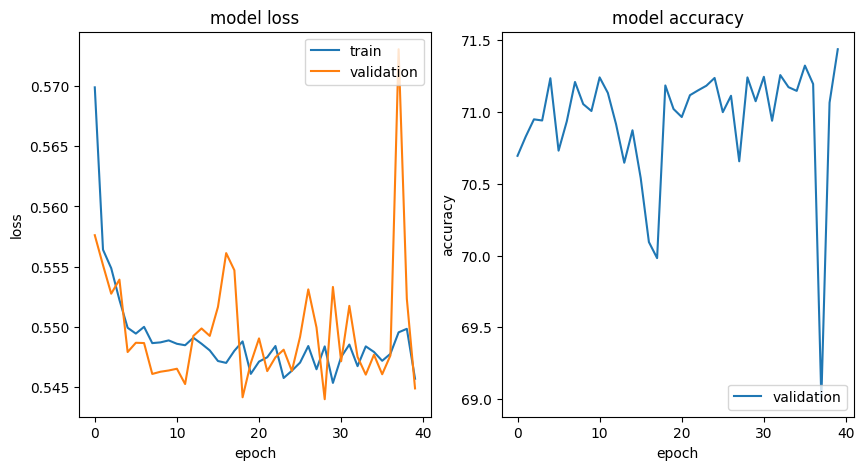

min train loss 0.545 at ep. 29
min valid loss 0.544 at ep. 28
best accurracy  71.44 at ep. 39


In [ ]:
# You can run the cell above several times to accumulate more epochs and then plot the history.
# If you need a fresh training with a modified model, rerun the above cell where the model is defined.
L.plotLearningCurves()

We see a maximal accuracy of about 71% to less then 72%. There is not much improvement in the accuracy after about the first 20 epochs.

### Performance

An accuracy of about 71%, which is already quite good for such a small network (and lot's of important things we did not even consider yet ...)!

Let's check how well the model generalized by evaluating the validation data and the train data and manually computing the accuracy.
* First, the model is put in *evaluation mode*. We *detach* then the data from the gradient tracking and move the data back to the CPU memory. Here, we can map to a numpy array.

In [ ]:
# evaluate all training and validation data again for further study
model.eval()
predictions_train = model(c_tensor_train).detach().cpu().numpy()
predictions_valid = model(c_tensor_valid).detach().cpu().numpy()

The preddiction is a float between between 0 and 1. We cut at 0.5 and count everything below as QCD and everything above as Top. The true labels had been loaded above.


In [ ]:
# sklearn provides an accurcy_score for numpy arrays
from sklearn.metrics import accuracy_score
acc_train = accuracy_score(predictions_train>0.5, labels_train)
acc_valid = accuracy_score(predictions_valid>0.5, labels_valid)
print(f"Accuracy on traing data {acc_train}")
print(f"Accuracy on validation data {acc_valid}")

Accuracy on traing data 0.71176
Accuracy on validation data 0.71436


This looks fairly similar, so for now, we don't seem to experience overtraining.

We proceed by taking a look at the output distributions of the validation dataset, separated into signal and background components.

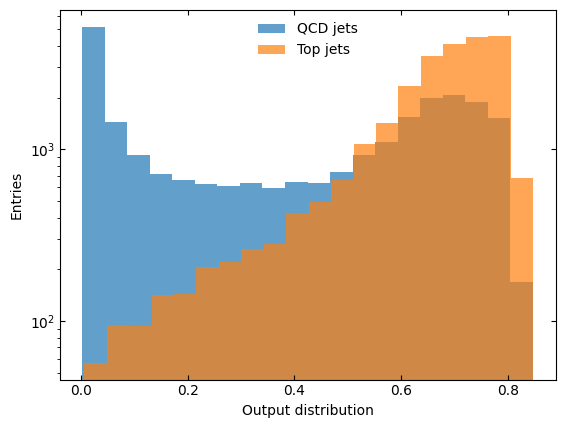

In [ ]:
hlp.plots.plot_hist(
    (predictions_valid[labels_valid == 0], predictions_valid[labels_valid == 1]),
    names=("QCD jets", "Top jets"),
    xlabel="Output distribution",
    log=True,
).show()

Besides the classification accuracy, we can study the *receiver operating characteristic* curve or **ROC** curve. It shows the relation between the true positive (jets *correctly* identified as top jets) and false positive rates (light jets *mistaken* as a top jets).

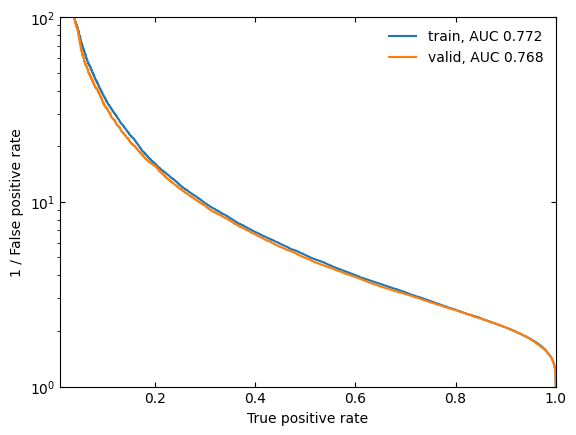

In [ ]:
# do the roc plot
hlp.plots.plot_roc(
    (labels_train, labels_valid),
    (predictions_train, predictions_valid),
    names=("train", "valid"),
).show()

The curves above are produced by scanning potential values to cut on the network output and examining the resulting signal classification (true positive) and background mis-classification (false positive) rates.

Naturally, a well performing network has a high true positive rate while keeping the (reciprocal) false positive rate at a reasonably low (high) level. For the choice of the axes above, this would lead to a curve that is bent towards the upper right corner. But be aware that other representations of the ROC curve exist which might look somewhat different (e.g. "1 - false positive rate" on the y-axis). Their message is, however, identical.

A commonly used proxy that compiles the values for all possible cuts into one metric is the area-under-curve - **AUC**. A value of 1 signalizes a perfectly working network that allows for a cut value leading to 100% signal efficiency and 0% background contamination. Opposed to that, a value of 0.5 means that the two output distributions of signal and background events are probably fully overlapping, lacking the opportunity to apply a cut that would favor signal examples. A value of 0 has the same logical meaning as 1, but the definition of what is signal and background is flipped. Therefore, the distance from 0.5 is what actually matters here.

A value above 0.75 is already quite decent, but there's still potential. You can try to beat this value in the full training setup below.

## Lessons learned

- Now we know how to build a simple model using PyTorch.
- To ensure model generalization, we evaluated validation data with our trainined model.
- We calculated accuracies and visualized the output distributions.
- We learned about ROC curves, AUC values and how to plot / compute them.

With these tools at hand, we can jump into the next section and improve our model.

# Part 5: Improving the model

Our input data - a selection of four-vectors with values given in GeV - clearly comes from the domain of physics. As we have seen in the plots above, their numerical values range from -500 to 500 for $p_x$ and $p_y$, and up to 2000 for $E$ and $p_z$ values.
Restricting to a range of -1 to 1 is often improving the performance. sklearn provides several
[scalers.](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#standardscaler). The MinMax scaler is popular but it depends strongly on the sample size. The StandardScaler is often a better choice. An alternative is to use a BatchNormalization layer as first layer.



There are many details that influence the performance of the model. An accuracy of 85% is easily possible.
Do some experiment with several aspects of the model:
* How many **epochs** are necessary to reach the best performance?
* What is the best value for the **learning rate**.
* **Preprocessing**
  * Feature normalization: MinMax or StandardScaler
  * Higher level features - Physical knowledge
* Network **archtecture**
  * how large can the layers become
  * Activation functions - ReLU
  * Convolutional layers (see separate lecture)
* **Regularisation**
  * Dropout
  * Batchnorm is a now popular choice
* Available training data size - **big data!**

A possible sequence of experiments
* _Tanh_ are especially sensitive to the proper normalization of the input features
  * Try to use either the sklearn _MinMaxScaler_,  _StandardScaler_ or a _BatchNorm1d_ as first layer

  * One _BatchNorm1d_ layer within the network is useful. It is not always obvious where to place it Try different position: 1st 2nd layer before after the activation
  * An accuracy of about 78% should be possible
  
* Replace *Tanh* by *ReLU*. The resulting network typically performes better but it is also more sensitive to overtraining
  * A first _BatchNorm1d_ is not useful
  * A smaller learning rate in Adam should be beneficial (0.01-_0.005_-0.0001) but not too small
  * A LR cool down is often beneficial to get the last little improvement. Uncomment the line where the optimizer (Adam) LR is modilfie with LR=0.001
  * An accuracy of about 86-87% should be possible
* Use the physically motivated transformation into invariants. Note that the input dimension is different
  * We see an imediant increase in performance and faster traing. 30 epochs are typical enough
  * An accuracy of about 90.2% should be possible
* A larger datset for traing (all 8 files) should give a slightly better accuracy (90.4%)

* The best model is not the last model. Save the best model during training. Load it and evaluate the model on the test dataset: Accuracy and ROC curve.

  




# Skorch
Before we start with the experimenting, let's introduce [skorch](https://skorch.readthedocs.io/en/latest/user/quickstart.html).
Pure PyTorch can be somewhat involved. There are tools to make our life easier by encapsulating the techincal details you have seen above.

Skorch works with callbacks. Callbacks are functions that are called at certain points in the processing loop. Especially: epoch start, epoch end, batch start, and batch end. Most common callbacks, e.g. for scoring, are predefined. The names explains the function.

In [ ]:
from skorch.callbacks import EpochScoring
auc = EpochScoring(scoring='roc_auc',  on_train=False,lower_is_better=False)
acc = EpochScoring(scoring='accuracy', on_train=True, lower_is_better=False)

Also saving the best model (checkpoints) is automated. The [Checkpoint](https://skorch.readthedocs.io/en/latest/callbacks.html#skorch.callbacks.Checkpoint) callback saves by default the model with the lowest validation loss. The *load_best* flag the best modelAll loging is done in the directory *chkpoints*. (BTW The left panel in Colab allows you to look into your home dir.)

In [ ]:
from skorch.callbacks import Checkpoint
cp = Checkpoint(dirname='chkpoints',load_best=True)

First we repeat the preprocessing from above. In addition, we wrap the validation data into a skorch dataset.

In [ ]:
from skorch.dataset import Dataset
from skorch.helper import predefined_split

def preprocess_constituents(constituents):
    return constituents[:, :120].reshape((-1, 480)).astype(np.float32)

# later we try something more fancy
#def preprocess_constituents(constituents):
#     c_sum=constituents.sum(axis=1)
#     metric=np.array([1.,-1.,-1.,-1.])
#     c_inv=(constituents*metric*c_sum[:,None,:]).sum(axis=2)
#     return c_inv

# load training data
c_vectors_train, _, labels_train = hlp.data.load("train", stop_file=2)
# the validation data
c_vectors_valid, _, labels_valid = hlp.data.load("valid", stop_file=1)

# run the preprocessing
c_vectors_train = preprocess_constituents(c_vectors_train)
c_vectors_valid = preprocess_constituents(c_vectors_valid)

#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
##scaler = MinMaxScaler()  # worst idea
#scaler.fit(c_vectors_train)
#c_vectors_train=scaler.transform(c_vectors_train)
#c_vectors_valid=scaler.transform(c_vectors_valid)

ds_valid = Dataset(c_vectors_valid, labels_valid)


Skorch provides a predefined training loop for a classifier. We put in
* our model,
* the loss as above (nn.BCELoss),
* the Adam optimizer as above.
* We use the same learning rate lr=0.005
* and the same batch size of 500.
* In addition, we add the data for validation.

Skorch works with numpy and creates the torch datasets internally. Moving back and forth between GPU, if available, and CPU memory is also handle internally. The training loop is performed by just calling *fit()*.

We start with the same model but with the first experiment with adding a batch norm layer.

In [ ]:
from torch import nn

model = nn.Sequential(
    nn.BatchNorm1d(480),
    nn.Linear(480, 256, bias=True),
    nn.Tanh(),
    #nn.BatchNorm1d(256),
    nn.Linear(256, 128, bias=True),
    nn.Tanh(),
    nn.Linear(128,   1, bias=True),
    nn.Sigmoid(),
)

In [ ]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    model,
    criterion=nn.BCELoss(),
    optimizer=torch.optim.Adam,
    lr=0.005,
    batch_size=500,
    max_epochs=20,
    callbacks=[acc,auc,cp],
    train_split=predefined_split(ds_valid),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    device=device
)

In [ ]:
net.fit(c_vectors_train, labels_train)

  epoch    accuracy    roc_auc    train_loss    valid_acc    valid_loss    cp     dur
-------  ----------  ---------  ------------  -----------  ------------  ----  ------
      1      0.7052     0.7687        0.5543       0.7122        0.5427     +  6.1606
      2      0.7109     0.7774        0.5424       0.7150        0.5381     +  6.0596
      3      0.7131     0.7756        0.5405       0.7140        0.5404        5.7635
      4      0.7159     0.7732        0.5387       0.7153        0.5400        6.0899
      5      0.7150     0.7772        0.5368       0.7110        0.5389        5.3111
      6      0.7150     0.7770        0.5366       0.7140        0.5370     +  6.1957
      7      0.7160     0.7764        0.5355       0.7149        0.5390        5.5952
      8      0.7150     0.7703        0.5347       0.7120        0.5433        6.4158
      9      0.7179     0.7797        0.5331       0.7157        0.5412        5.3702
     10      0.7174     0.7796        0.5333       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): BatchNorm1d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=480, out_features=256, bias=True)
    (2): Tanh()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Tanh()
    (5): Linear(in_features=128, out_features=1, bias=True)
    (6): Sigmoid()
  ),
)

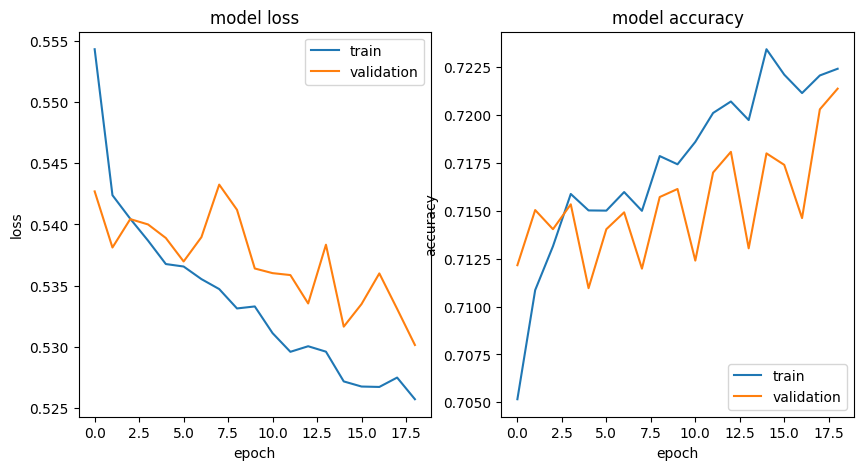

min train loss 0.526 at ep. 18
min valid loss 0.530 at ep. 18
best valid accurracy   0.72 at ep. 18


In [ ]:
# Skorch comes with a history object. We have predefined some plots.
hlp.plots.plotLearningCurvesSkorch(net.history)

Maybe not yet the optimal accuracy? Skorch allows to continue the traing: *partial_fit* instead of *fit*.


In [ ]:
net.partial_fit(c_vectors_train, labels_train)

     20      0.7243     0.7867        0.5246       0.7208        0.5299     +  5.5473
     21      0.7245     0.7805        0.5236       0.7166        0.5420        5.9884
     22      0.7260     0.7861        0.5229       0.7219        0.5317        5.5894
     23      0.7256     0.7894        0.5218       0.7226        0.5280     +  5.7260
     24      0.7272     0.7864        0.5202       0.7193        0.5333        6.0363
     25      0.7279     0.7892        0.5208       0.7196        0.5271     +  5.5804
     26      0.7293     0.7883        0.5184       0.7193        0.5301        6.4291
     27      0.7290     0.7847        0.5175       0.7178        0.5336        5.5233
     28      0.7292     0.7907        0.5168       0.7221        0.5281        6.3055
     29      0.7318     0.7884        0.5142       0.7176        0.5281        6.1109
     30      0.7328     0.7903        0.5144       0.7230        0.5261     +  6.4061
     31      0.7330     0.7918        0.5130       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): BatchNorm1d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=480, out_features=256, bias=True)
    (2): Tanh()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Tanh()
    (5): Linear(in_features=128, out_features=1, bias=True)
    (6): Sigmoid()
  ),
)

The epoch with the best validation loss is marked by a '+'.

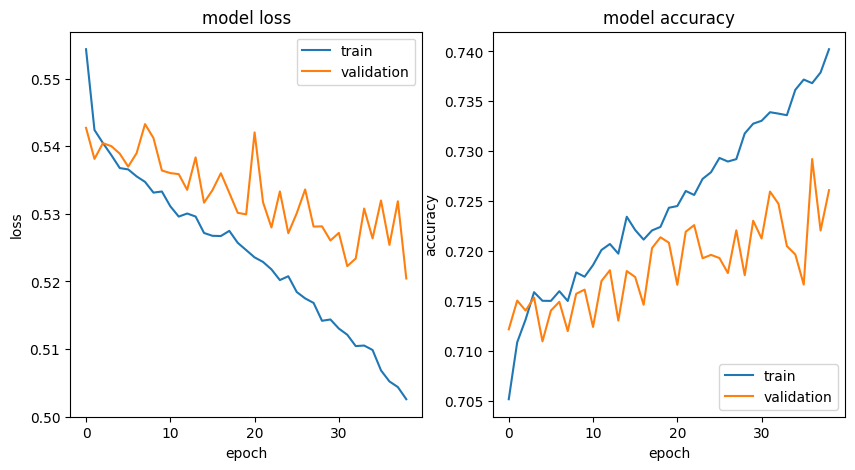

min train loss 0.503 at ep. 38
min valid loss 0.520 at ep. 38
best valid accurracy   0.74 at ep. 36


In [ ]:
hlp.plots.plotLearningCurvesSkorch(net.history)

0.7288     0.7860        0.5173       0.7206        0.5295  
The trained net can be used for predictions at the best (validation loss) model:
```python
net.load_params(checkpoint=cp)
net.predict_proba(data)
```

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score
# net.predict_proba gives 2 probability (background/signal)
# as expected from sklearn classifiers
# here, we need only the second value
net.load_params(checkpoint=cp)
predictions_train = net.predict_proba(c_vectors_train)[:,1]
predictions_valid = net.predict_proba(c_vectors_valid)[:,1]
acc_train = accuracy_score(labels_train,predictions_train>0.5)
auc_train = roc_auc_score(labels_train,predictions_train)
acc_valid = accuracy_score(labels_valid,predictions_valid>0.5)
auc_valid = roc_auc_score(labels_valid,predictions_valid)
print(f'train      - acc {acc_train:.4f} \tauc {auc_train:.4f} ')
print(f'validation - acc {acc_valid:.4f} \tauc {auc_valid:.4f} ')


train      - acc 0.7511 	auc 0.8314 
validation - acc 0.7261 	auc 0.7991 


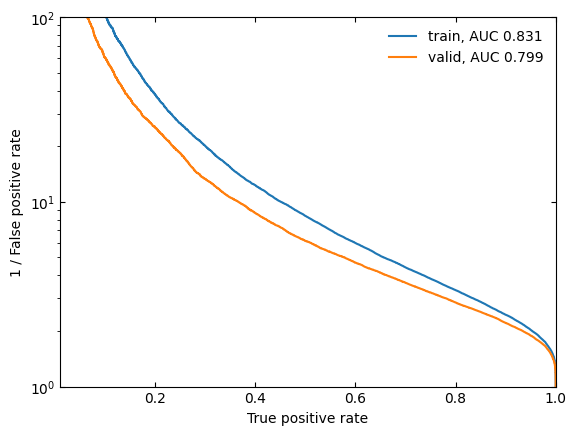

In [ ]:
# do the roc plot
hlp.plots.plot_roc(
    (labels_train, labels_valid),
    (predictions_train, predictions_valid),
    names=("train", "valid"),
).show()

Happy experimenting!